<h1>ATSC 409</h1>
<h2>Miniproject 2<h2>
<h3>Timothy Chui</h3>
<h3>37695129</h3>

In [1]:
# make new yaml file for miniproject

import yaml
timevars={'timevars':{'dt':0.1,'tstart':0.0,'tend':100.0}}
# chid = constant death of daisies
# chir = constant death of rabbits
# chif = constant death of foxes

# phi = proportionality constant for daisy death due to rabbits
# theta = proportionality constant for rabbit death due to foxes

# betar = constant growth rate of rabbits
# betaf = constant growth rate of foxes

# initialize yaml file for rabbits only, no foxes (i.e. set all fox-based parameters to 0)
uservars={'uservars':{'albedo_white':0.75,'chid':0.3,'chir':0.3,'chif':0.0,'phi':1,'theta':0.0,
                      'betar':0.5,'betaf':0.0,'S0':3668.0,'L':1.1,'albedo_black':0.25,
                      'R':0.12,'sigma':5.67e-08,'albedo_ground':0.5}} 
initvars={'initvars':{'whiteconc':0.2,'blackconc':0.7, 'rabbitconc':0.1, 'foxconc':0.0}} # add rabbit and fox conc.
adaptvars={'adaptvars':{'dtpassmin':0.1,'dtfailmax':0.5,'dtfailmin':0.1,'s':0.9,'rtol':1.0e-05,
           'atol':1.0e-05,'maxsteps':2000.0,'maxfail':60.0,'dtpassmax':5.0}}

with open('miniproject_2.yaml','w') as f:
    f.write(yaml.dump(timevars,default_flow_style=False))
    f.write(yaml.dump(uservars,default_flow_style=False))
    f.write(yaml.dump(initvars,default_flow_style=False))
    f.write(yaml.dump(adaptvars,default_flow_style=False))   

In [2]:
# function to load/restart yaml file, and initialize the dictionaries for easy edits
def reset_params():
    with open("miniproject_2.yaml", "r") as yaml_file:
        yaml_all = yaml.load(yaml_file)
        uservars_init = yaml_all["uservars"]
        initvars_init = yaml_all["initvars"]
    return uservars_init, initvars_init

In [3]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

class IntegProject(Integrator):
    """Child of Integrator class for dealing with rabbit and fox populations as well
       Adapted from Integ54; includes mammal population and its effects on the daisy population
    """

    def set_yinit(self, uservars_init, initvars_init):
        # set new initial conditions
        for init_key in initvars_init:
            self.config["initvars"][init_key] = initvars_init[init_key]
        
        # set new parameters
        for user_key in uservars_init:
            self.config["uservars"][user_key] = uservars_init[user_key]
        
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc, self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name, uservars_init, initvars_init):
        super().__init__(coeff_file_name)
        self.set_yinit(uservars_init, initvars_init)

        
    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=rabbits/area
           y[3]=foxes/area
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        beta_b, beta_w = self.find_growth(temp_b, temp_w) # overwrote to use new find_growth method
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 4 element vector to hold the derivative
        f = np.empty_like(y)
        chi_daisies = user.phi*y[2] + user.chid # death rate of daisies
        chi_rabbits = user.theta*y[3] + user.chir # death rate of rabbits
        f[0] = y[0] * (beta_w * bare - chi_daisies) # white daisies
        f[1] = y[1] * (beta_b * bare - chi_daisies) # black daisies
        f[2] = y[2] * (user.betar*(1-bare) - chi_rabbits) # rabbits
        f[3] = y[3] * (user.betaf*y[2] - user.chif) # foxes
        return f
    
    # make new method for calculating growth rates
    def find_growth(self, temp_b, temp_w):
        """Calculate growth rates based on local temperatures"""
        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        return beta_b, beta_w


black = 0.1367151956268895

white = 0.4668500040867656

rabbits = 0.06792751404588866

foxes = 0.0



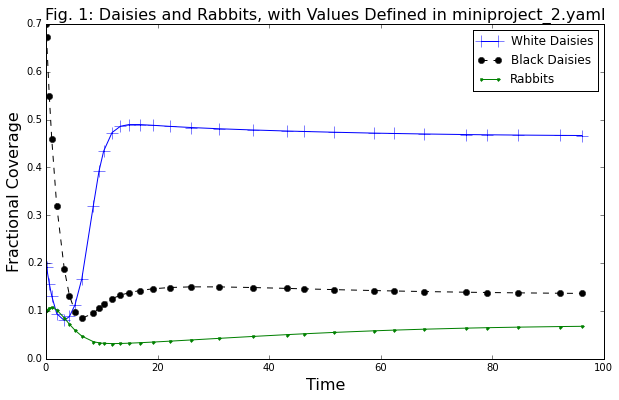

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# set dictionaries to play around with initial conditions and parameters
uservars_init,initvars_init = reset_params()

# call class and integrate forward in time
theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbits','foxes'])

# plot fractional coverage with time, for case with no foxes
thefig1,theAx1=plt.subplots(1,1, figsize=(10,6))

points,=theAx1.plot(timeVals,yvals['white'],'-b+',label='White Daisies')
points.set_markersize(12)
theLine1,=theAx1.plot(timeVals,yvals['black'],'--ko',label='Black Daisies')
theLine2,=theAx1.plot(timeVals,yvals['rabbits'],'-g.',label='Rabbits')
theAx1.set_title('Fig. 1: Daisies and Rabbits, with Values Defined in miniproject_2.yaml', fontsize=16)
theAx1.set_xlabel('Time', fontsize=16)
theAx1.set_ylabel('Fractional Coverage', fontsize=16)
out=theAx1.legend(loc='best')

print("black = {}\n".format(yvals['black'].iloc[-1]))
print("white = {}\n".format(yvals['white'].iloc[-1]))
print("rabbits = {}\n".format(yvals['rabbits'].iloc[-1]))
print("foxes = {}\n".format(yvals['foxes'].iloc[-1]))

In [5]:
# now play around with initial conditions

def plot_final(is_init, change_key, change_array, uservars_init, initvars_init):
    """Facilitates plotting of final values
    
       is_init = True if taken from initvars_init, False if from uservars_init
       change_key = dictionary key 
       change_array = array of initial values or parameters
       uservars_init = dictionary of uservars
       initvars_init = dictionary of initvars
    """
    
    # make arrays for final values
    white_end = []
    black_end = []
    rabbit_end = []

    for each_change in change_array:
        if is_init:
            initvars_init[change_key] = each_change
        else:
            uservars_init[change_key] = each_change
        theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
        timeVals,yVals,errorList=theSolver.timeloop5Err()

        white_end.append(yVals[-1,0])
        black_end.append(yVals[-1,1])
        rabbit_end.append(yVals[-1,2])
        
    thefig,theAx=plt.subplots(1,1,figsize=(10,4))
    points,=theAx.plot(change_array,white_end,'-b+',label='White Daisies')
    points.set_markersize(12)
    theLine1,=theAx.plot(change_array,black_end,'--ko',label='Black Daisies')
    theLine2,=theAx.plot(change_array,rabbit_end,'-g.',label='Rabbits')
    
    out=theAx.legend(loc='best')
    
    return thefig,theAx
    


In [6]:
# helper function for plotting timeseries
def plot_timeseries(is_init, change_key, change_array, label, uservars_init, initvars_init):
    """Facilitates plotting of final values
    
       is_init = True if taken from initvars_init, False if from uservars_init
       change_key = dictionary key 
       change_array = array of initial values or parameters
       label = variable to put into legend
       uservars_init = dictionary of uservars
       initvars_init = dictionary of initvars
    """
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    
    thefig,theAx=plt.subplots(3,1, figsize=(10,6))
    
    jet = plt.get_cmap('jet')  # use colormap for to change colour of each line as the plots are made
    cNorm  = colors.Normalize(vmin=change_array[0], vmax=change_array[-1]) # normalize colour to values in change_array
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    for idx in range(change_array.shape[0]):
        if is_init:
            initvars_init[change_key] = change_array[idx]
        else:
            uservars_init[change_key] = change_array[idx]
        colorVal = scalarMap.to_rgba(change_array[idx])
        theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
        timeVals,yVals,errorList=theSolver.timeloop5Err()
        theAx[0].plot(timeVals,yVals[:,0],'-',color=colorVal)
        theAx[1].plot(timeVals,yVals[:,1],'-',color=colorVal)
        theAx[2].plot(timeVals,yVals[:,2],'-',color=colorVal,label="{} = {:.2f}".format(label, change_array[idx]))

    theAx[0].set_ylabel('White Daisies', fontsize=12)
    theAx[1].set_ylabel('Black Daisies', fontsize=12)
    theAx[2].set_xlabel('Time', fontsize=12)
    theAx[2].set_ylabel('Rabbits', fontsize=12)
    
    out=theAx[2].legend(loc='center left', bbox_to_anchor=(1.05, 1.5))
    
    return thefig,theAx

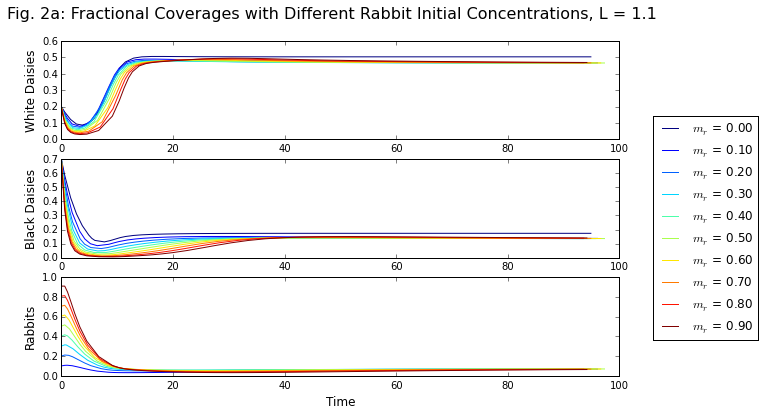

In [7]:
# different rabbit initial conditions
uservars_init,initvars_init = reset_params() # reset initial parameters

rabbit_inits = np.arange(0.0,1.00,0.1)
is_init = True
change_key = "rabbitconc"
label = r"$m_r$"

thefig2a,theAx2a=plot_timeseries(is_init, change_key, rabbit_inits, label, uservars_init, initvars_init)
thefig2a.suptitle('Fig. 2a: Fractional Coverages with Different Rabbit Initial Concentrations, L = {:.2}'.format(uservars_init["L"]),
                  fontsize=16)

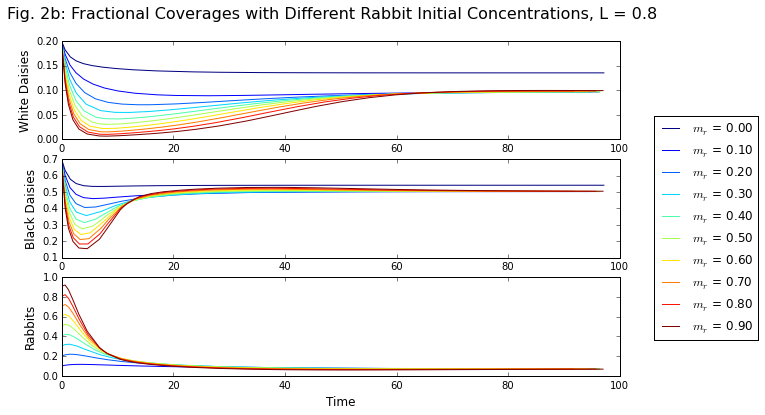

In [8]:
# but what about with a lower L?
uservars_init,initvars_init = reset_params() # reset initial parameters

rabbit_inits = np.arange(0.0,1.00,0.1)
is_init = True
change_key = "rabbitconc"
label = r"$m_r$"

uservars_init["L"] = 0.8
thefig2b,theAx2b=plot_timeseries(is_init, change_key, rabbit_inits, label, uservars_init, initvars_init)
thefig2b.suptitle('Fig. 2b: Fractional Coverages with Different Rabbit Initial Concentrations, L = {:.2}'.format(uservars_init["L"]),
                  fontsize=16)

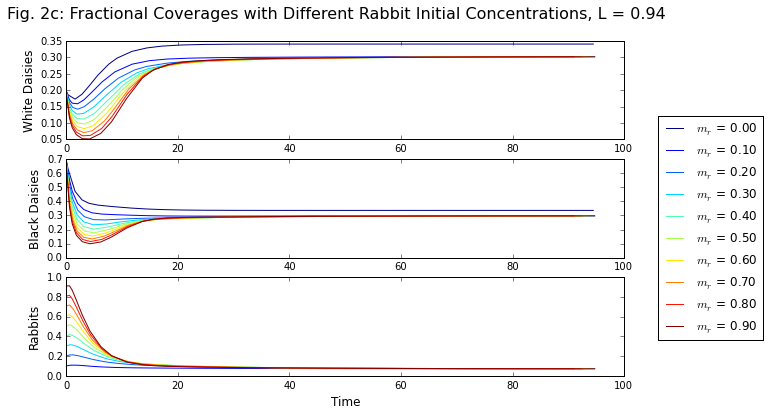

In [9]:
# what about a middle-of-the-ground L?
uservars_init,initvars_init = reset_params() # reset initial parameters

rabbit_inits = np.arange(0.0,1.00,0.1)
is_init = True
change_key = "rabbitconc"
label = r"$m_r$"

uservars_init["L"] = 0.940
thefig2c,theAx2c=plot_timeseries(is_init, change_key, rabbit_inits, label, uservars_init, initvars_init)
thefig2c.suptitle('Fig. 2c: Fractional Coverages with Different Rabbit Initial Concentrations, L = {:.2}'.format(uservars_init["L"]),
                  fontsize=16)

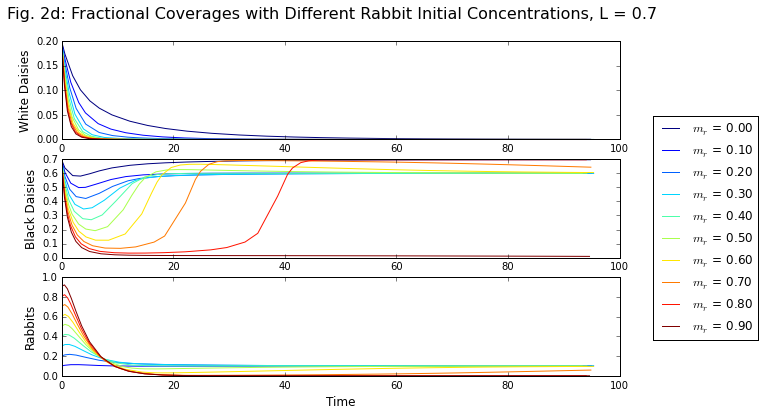

In [10]:
# what about a really low L? 
uservars_init,initvars_init = reset_params() # reset initial parameters

rabbit_inits = np.arange(0.0,1.00,0.1)
is_init = True
change_key = "rabbitconc"
label = r"$m_r$"

uservars_init["L"] = 0.7
thefig2d,theAx2d=plot_timeseries(is_init, change_key, rabbit_inits, label, uservars_init, initvars_init)
thefig2d.suptitle('Fig. 2d: Fractional Coverages with Different Rabbit Initial Concentrations, L = {:.2}'.format(uservars_init["L"]),
                  fontsize=16)

(0, 0.2)

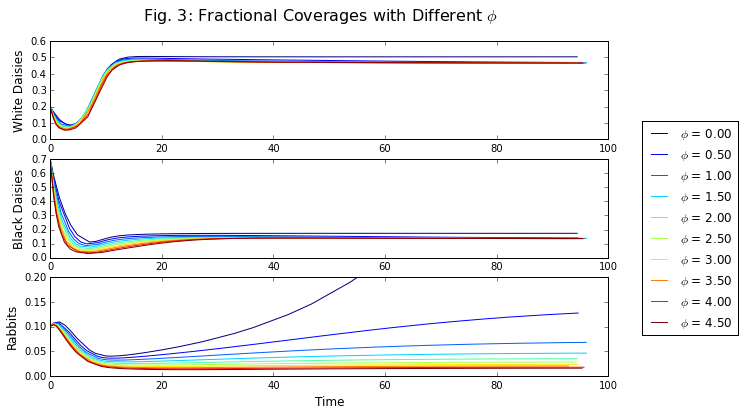

In [11]:
# now play around with the death rate of daisies due to the rabbits (i.e. how much do rabbits eat?)
uservars_init,initvars_init = reset_params() # reset initial parameters

phis = np.arange(0.0,5.0,0.5)
is_init = False
change_key = "phi"
label = r"$\phi$"

thefig3,theAx3=plot_timeseries(is_init, change_key, phis, label, uservars_init, initvars_init)
thefig3.suptitle('Fig. 3: Fractional Coverages with Different $\phi$',
                  fontsize=16)
theAx3[2].set_ylim([0, 2*initvars_init["rabbitconc"]])

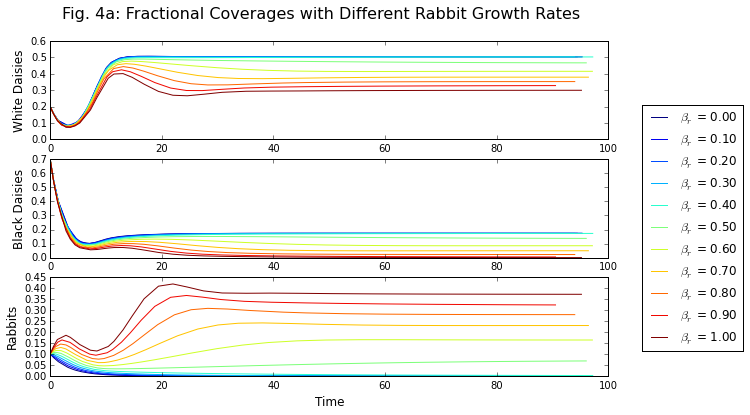

In [12]:
# now try a range of growth rates
uservars_init,initvars_init = reset_params() # reset initial parameters

betasr = np.arange(0.0,1.1,0.1) # small values of beta
is_init = False
change_key = "betar"
label = r"$\beta_r$"

thefig4a,theAx4a=plot_timeseries(is_init, change_key, betasr, label, uservars_init, initvars_init)
thefig4a.suptitle('Fig. 4a: Fractional Coverages with Different Rabbit Growth Rates', fontsize=16)

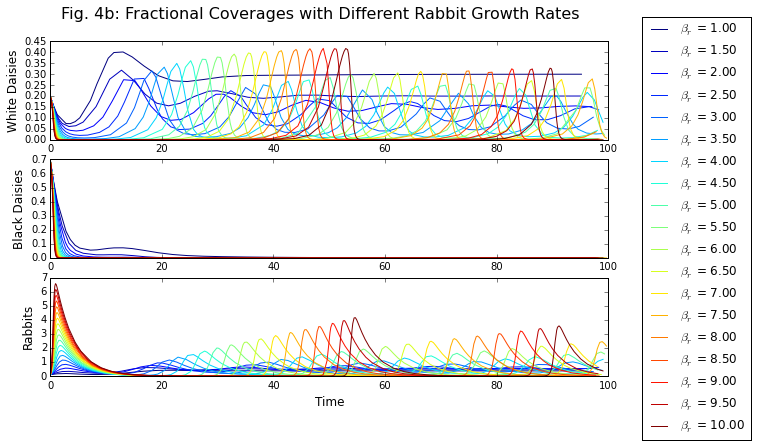

In [13]:
uservars_init,initvars_init = reset_params() # reset initial parameters

betasr = np.arange(1.0,10.5,0.5) # large values of beta

is_init = False
change_key = "betar"
label = r"$\beta_r$"

thefig4b,theAx4b=plot_timeseries(is_init, change_key, betasr, label, uservars_init, initvars_init)
thefig4b.suptitle('Fig. 4b: Fractional Coverages with Different Rabbit Growth Rates', fontsize=16)

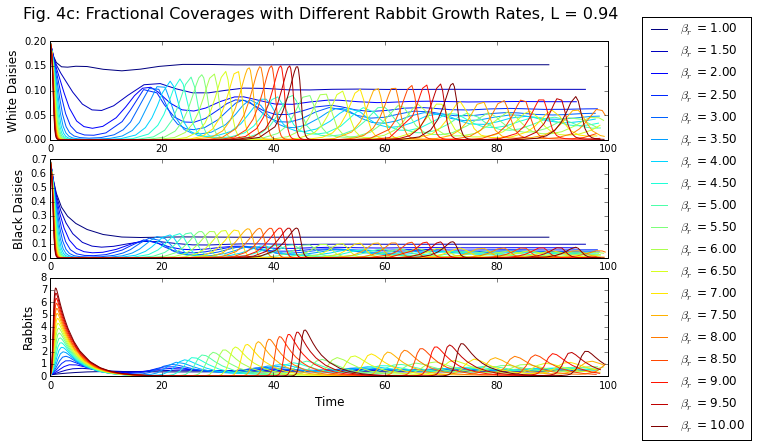

In [14]:
uservars_init,initvars_init = reset_params() # reset initial parameters

betasr = np.arange(1.0,10.5,0.5) # large values of beta

is_init = False
change_key = "betar"
label = r"$\beta_r$"

uservars_init["L"] = 0.940
thefig4c,theAx4c=plot_timeseries(is_init, change_key, betasr, label, uservars_init, initvars_init)
thefig4c.suptitle('Fig. 4c: Fractional Coverages with Different Rabbit Growth Rates, L = {}'.format(uservars_init["L"]), 
                  fontsize=16)

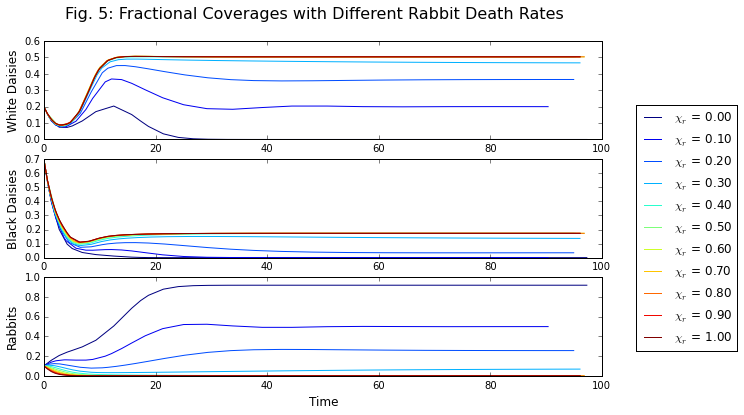

In [15]:
uservars_init,initvars_init = reset_params() # reset initial parameters

# now play around with the death rate of rabbits

uservars_init,initvars_init = reset_params() # reset initial parameters

chisr = np.arange(0.0, 1.1, 0.1) 

is_init = False
change_key = "chir"
label = r"$\chi_r$"

thefig5,theAx5=plot_timeseries(is_init, change_key, chisr, label, uservars_init, initvars_init)
thefig5.suptitle('Fig. 5: Fractional Coverages with Different Rabbit Death Rates', 
                  fontsize=16)

In [16]:
# helper function for plotting timeseries; edited for foxes
def plot_timeseries(is_init, change_key, change_array, label, uservars_init, initvars_init):
    """Facilitates plotting of final values
    
       is_init = True if taken from initvars_init, False if from uservars_init
       change_key = dictionary key 
       change_array = array of initial values or parameters
       label = variable to put into legend
       uservars_init = dictionary of uservars
       initvars_init = dictionary of initvars
    """
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    
    thefig,theAx=plt.subplots(4,1, figsize=(10,6)) # edit to include foxes
    
    jet = plt.get_cmap('jet')  # use colormap for to change colour of each line as the plots are made
    cNorm  = colors.Normalize(vmin=change_array[0], vmax=change_array[-1]) # normalize colour to values in change_array
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    for idx in range(change_array.shape[0]):
        if is_init:
            initvars_init[change_key] = change_array[idx]
        else:
            uservars_init[change_key] = change_array[idx]
        colorVal = scalarMap.to_rgba(change_array[idx])
        theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
        timeVals,yVals,errorList=theSolver.timeloop5Err()
        theAx[0].plot(timeVals,yVals[:,0],'-',color=colorVal)
        theAx[1].plot(timeVals,yVals[:,1],'-',color=colorVal)
        theAx[2].plot(timeVals,yVals[:,2],'-',color=colorVal, label="{} = {:.2f}".format(label, change_array[idx]))
        theAx[3].plot(timeVals,yVals[:,3],'-',color=colorVal) # foxes

    theAx[0].set_ylabel('White Daisies', fontsize=12)
    theAx[1].set_ylabel('Black Daisies', fontsize=12)
    theAx[2].set_xlabel('Time', fontsize=12)
    theAx[2].set_ylabel('Rabbits', fontsize=12)
    theAx[3].set_ylabel('Foxes', fontsize=12)
    
    out=theAx[2].legend(loc='center left', bbox_to_anchor=(1.05, 1.5))
    
    return thefig,theAx

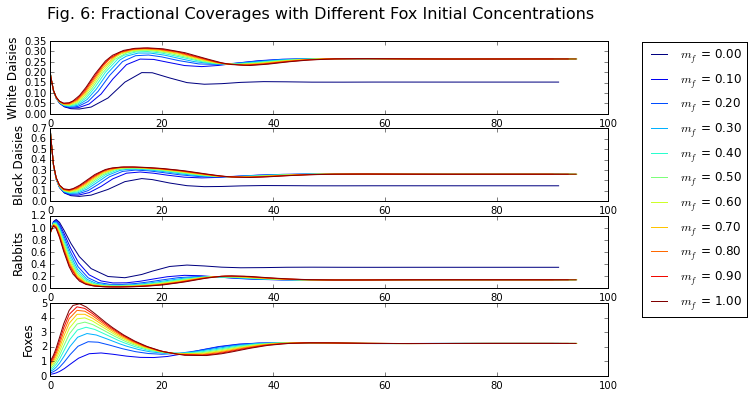

In [46]:
# now we introduce foxes!!

uservars_init,initvars_init = reset_params() # reset initial parameters

foxes_inits = np.arange(0.0,1.1,0.1)
is_init = True
change_key = "foxconc"
label = r"$m_f$"

uservars_init["L"] = 0.940 # set L = 0.940 to allow black and white daisies to "feel comfortable"
initvars_init["rabbitconc"] = 0.9
uservars_init["betar"] = 1.0
uservars_init["chir"] = 0.3

uservars_init["theta"] = 0.1
uservars_init["betaf"] = 0.7
uservars_init["chif"] = 0.1

thefig6,theAx6=plot_timeseries(is_init, change_key, foxes_inits, label, uservars_init, initvars_init)
thefig6.suptitle('Fig. 6: Fractional Coverages with Different Fox Initial Concentrations',
                  fontsize=16)

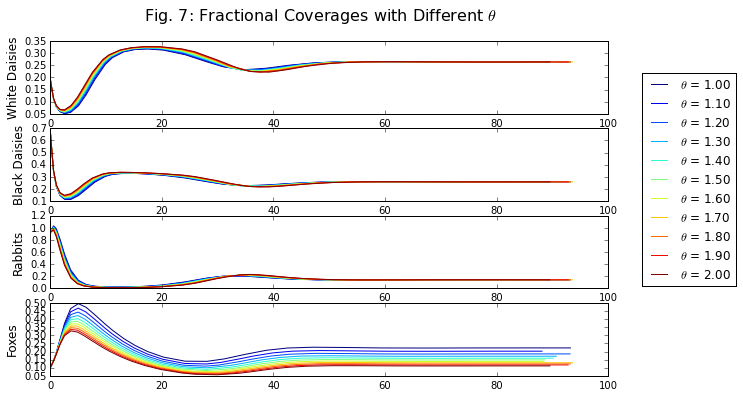

In [60]:
# vary rate at which foxes eat rabbit
uservars_init,initvars_init = reset_params() # reset initial parameters

thetas = np.arange(1.0,2.1,0.1)
is_init = False
change_key = "theta"
label = r"$\theta$"

uservars_init["L"] = 0.940 
initvars_init["rabbitconc"] = 0.9
initvars_init["foxconc"] = 0.1

uservars_init["betar"] = 1.0
uservars_init["chir"] = 0.3

uservars_init["betaf"] = 0.7
uservars_init["chif"] = 0.1

thefig7,theAx7=plot_timeseries(is_init, change_key, thetas, label, uservars_init, initvars_init)
thefig7.suptitle(r"Fig. 7: Fractional Coverages with Different $\theta$",
                  fontsize=16)

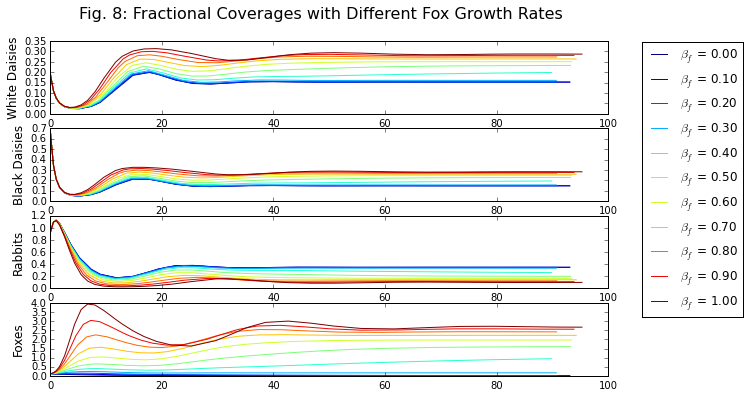

In [115]:
# vary fox growth rates
uservars_init,initvars_init = reset_params() # reset initial parameters

betasf = np.arange(0,1.1,0.1)
is_init = False
change_key = "betaf"
label = r"$\beta_f$"

uservars_init["L"] = 0.940 
initvars_init["rabbitconc"] = 0.9
initvars_init["foxconc"] = 0.1

uservars_init["betar"] = 1.0
uservars_init["chir"] = 0.3

uservars_init["theta"] = 0.1
uservars_init["chif"] = 0.1

thefig8,theAx8=plot_timeseries(is_init, change_key, betasf, label, uservars_init, initvars_init)
thefig8.suptitle(r"Fig. 8: Fractional Coverages with Different Fox Growth Rates",
                  fontsize=16)

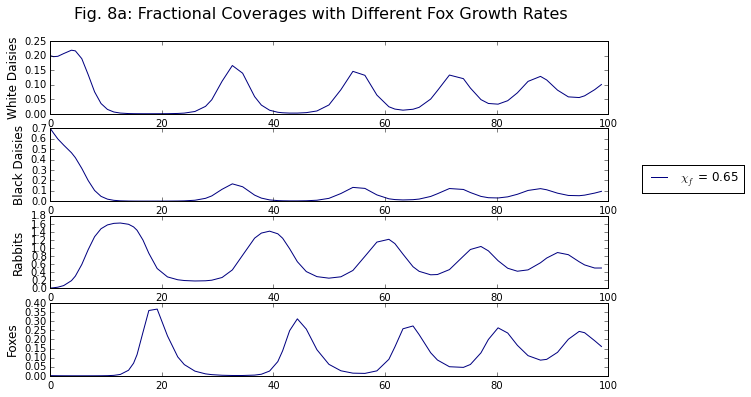

In [174]:
# vary fox growth rates
uservars_init,initvars_init = reset_params() # reset initial parameters

chisf = np.arange(0.1,1.0,0.1)


is_init = False
change_key = "chif"
label = r"$\chi_f$"

uservars_init["L"] = 0.940 
initvars_init["rabbitconc"] = 0.01
initvars_init["foxconc"] = 0.001

uservars_init["phi"] = 1
uservars_init["chid"] = 0.1


uservars_init["betar"] = 1

uservars_init["chir"] = 0

uservars_init["theta"] = 1
uservars_init["betaf"] = 1
#uservars_init["chif"] = 0.3
chisf = np.array([0.65])

thefig8c,theAx8c=plot_timeseries(is_init, change_key, chisf, label, uservars_init, initvars_init)
thefig8c.suptitle(r"Fig. 8a: Fractional Coverages with Different Fox Growth Rates",
                  fontsize=16)
